# EE-411 Fundamentals of inference and learning, EPFL 
## Exercise Session 3: Classification using k-Nearest Neighbors

In this third set of exercises we will start to see an application of supervised learning, introducing one of the simplest-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems: **k-Nearest Neighbors (KNN)**.

**What you will learn today:** In this third session, we will construct the kNN algorithm by hand, explaining different ways in which you can compute the distance between elements of a matrix. We will compute the train error and the test error, and we will see how they behave as a function of the parameter $k$ or of the degrees of freedom $N/k$. Then, we will introduce **scikit-learn** that allows us to implement kNN (and much more) in a very simple way. Finally, we will apply what we have learnt to a real, and very famous, dataset.

In [51]:
%matplotlib inline
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 9)
plt.rcParams["font.size"] = 15

Let us first generate some synthetic data. We will assume that we **know** what is the probability distribution of our datapoints, pay attention that usually we do not know it! 
Our **Generative Model** will be a Gaussian mixture model (GMM): 
* Assume that centroids from class zero and one are geneterated Gaussianly as follows
 $${\vec m}_k^{(0)} \sim \mathcal{N} (\vec{\mu} = [1,0] ; I_2) \qquad {\vec m}_k^{(1)} \sim \mathcal{N} (\vec{\mu} = [0,1] ; I_2) $$ 
* For each class, sample 10 different centroids ${\vec m}_k$
* Sample the actual data from $\mathcal{N} ({\vec m}_k, \frac{1}{5} I_2)$.

Let's sample the centroids and plot them

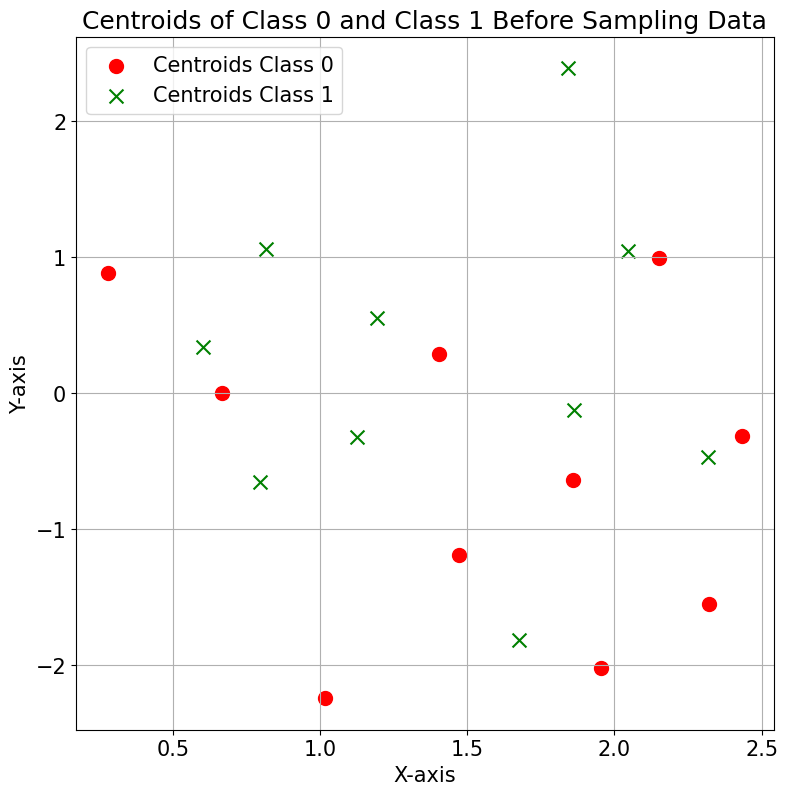

In [52]:
# Coding together #
mean_class_0 = np.array([1,0])
mean_class_1= np.array([1,0])
cov_identity = np.eye(2)

n_centroid = 10
centroids_class_0 = np.random.multivariate_normal(mean_class_0, cov_identity, n_centroid)
centroids_class_1 = np.random.multivariate_normal(mean_class_1, cov_identity, n_centroid)

plt.figure()
plt.scatter(centroids_class_0[:, 0], centroids_class_0[:, 1], color='red', marker='o', s=100, label='Centroids Class 0')
plt.scatter(centroids_class_1[:, 0], centroids_class_1[:, 1], color='green', marker='x', s=100, label='Centroids Class 1')

plt.title('Centroids of Class 0 and Class 1 Before Sampling Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

Once we have the centroids we can sample the actual data

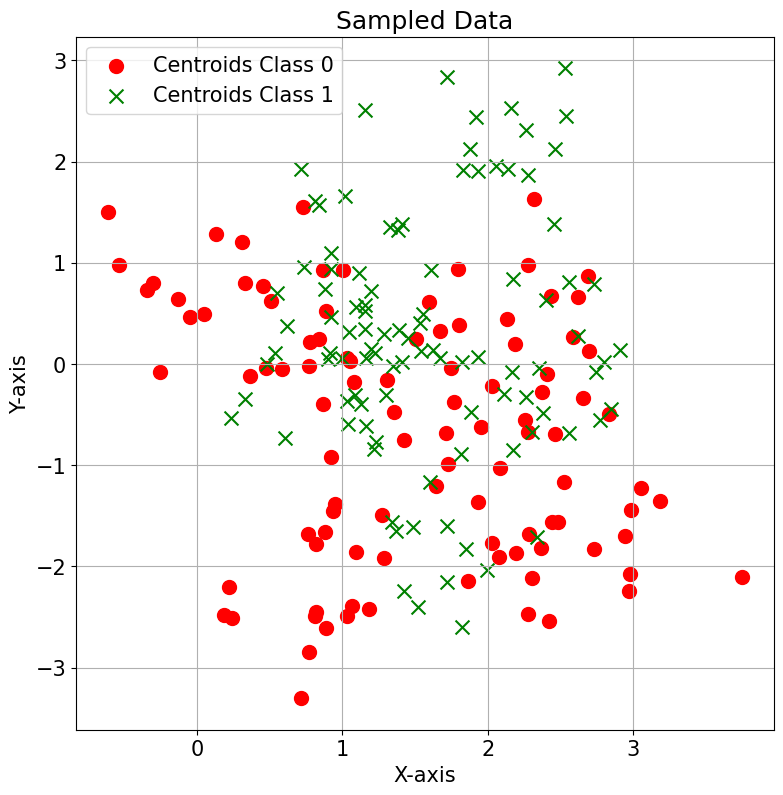

In [53]:
# Coding together #
point_per_centroid = 100

# Randomly assign each sample to one of the centroids (10 centroids per class)
class0_centroid_indices = np.random.randint(10, size=point_per_centroid)
class1_centroid_indices = np.random.randint(10, size=point_per_centroid)

# Generate samples by adding Gaussian noise around the selected centroids
class0_samples = centroids_class_0[class0_centroid_indices] + np.sqrt(1 / 5) * np.random.randn(point_per_centroid, 2)
class1_samples = centroids_class_1[class1_centroid_indices] + np.sqrt(1 / 5) * np.random.randn(point_per_centroid, 2)

data_class_0 = np.vstack(class0_samples)  # Stack the arrays vertically
data_class_1 = np.vstack(class1_samples)

plt.figure()
plt.scatter(data_class_0[:, 0], data_class_0[:, 1], color='red', marker='o', s=100, label='Centroids Class 0')
plt.scatter(data_class_1[:, 0], data_class_1[:, 1], color='green', marker='x', s=100, label='Centroids Class 1')

plt.title('Sampled Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

This is the problem that we want to solve: we are given these points and we want to find a decision boundary that ensures good generalization.
This is in general our goal: we want to be able to correctly classify new samples, never seen before, once they are given to us.

Let us group the data in a nice way. For binary classification problems like this one, the way data is usually arranged is in

- a matrix $X$ of size $N \times P$, where $N$ is the number of samples and $P$ is the number of features (in our case $N = 200$ and $P = 2$); the nomenclature "feature" is not always clear but usually we mean with it the dimension of the space in which the datapoints leave.
- a label vector $y \in \{0, 1\}^N$ saying to which class each sample belongs to

In [54]:
# Coding together #
#Generate X matrix 
X = np.vstack((data_class_0, data_class_1))
#generate Y
Y = np.hstack((np.zeros(len(data_class_0)), np.ones(len(data_class_1))))

Next we compute the distance matrix, a $N \times N$ matrix containing the distance from each sample to all others (do we really need to?)



In [55]:
# Coding together #
from scipy.spatial.distance import cdist

# Compute the pairwise Euclidean distance matrix (N x N)
D = cdist(X, X, metric='euclidean')  # Shape: (N=200, N=200)

If you know already Python, you can recognize that it is not an efficient implementation. 

We wanto to minimize *for* loops in Python! This is a general rule.

In [56]:
# Coding together #

In [57]:
# Coding together #

Using the distance matrix we can now write our algorithm!

**Workflow**: 
* Write a function that compute the $k$-nearest neighbor estimate for each point in the training set.
* Use this function to assign a class to each point by majority vote choosing a $k$ of your choice
* Compute the *training error* 


**Tip**: look up for the `np.argpartition` function.



In [58]:
# Coding together #
help(np.argpartition)

Help on _ArrayFunctionDispatcher in module numpy:

argpartition(a, kth, axis=-1, kind='introselect', order=None)
    Perform an indirect partition along the given axis using the
    algorithm specified by the `kind` keyword. It returns an array of
    indices of the same shape as `a` that index data along the given
    axis in partitioned order.

    .. versionadded:: 1.8.0

    Parameters
    ----------
    a : array_like
        Array to sort.
    kth : int or sequence of ints
        Element index to partition by. The k-th element will be in its
        final sorted position and all smaller elements will be moved
        before it and all larger elements behind it. The order of all
        elements in the partitions is undefined. If provided with a
        sequence of k-th it will partition all of them into their sorted
        position at once.

        .. deprecated:: 1.22.0
            Passing booleans as index is deprecated.
    axis : int or None, optional
        Axis along wh

Let's write down the function which compute the $k$-nearest neighbour for each datapoint.

In [59]:
# Coding together #
def knn(X, y, k):
    distance_matrix = cdist(X, X, metric='euclidean')
    
    # Initialize an array to store the predicted labels
    predictions = np.zeros(len(y), dtype=y.dtype)

    # Loop through each point to find its k-nearest neighbors
    for i in range(len(y)):
        # Get the indices of the k nearest neighbors
        nearest_indices = np.argpartition(distance_matrix[i], k)[:k]
        
        # Get the labels of the k nearest neighbors
        nearest_labels = y[nearest_indices]
        
        # Predict the label for the current point by majority vote
        predictions[i] = np.bincount(nearest_labels.astype(int)).argmax()

    return predictions

Now compute the estimated labels for a given instance $(X,y)$ at a fixed $k$ (e.g. $k=10$).

Once we have the estimated labels we are ready to compute the *training error*.

In [60]:
# Coding together #
label = knn(X, Y, 10)
print(label)
train_error = np.mean(Y != label)
print(train_error)

[1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0.]
0.25


The first half of the vector should be composed solely of 0's, and the second half should be composed of 1's; we can see however that there are some mistakes. Let us plot them to try to understand what is happening.

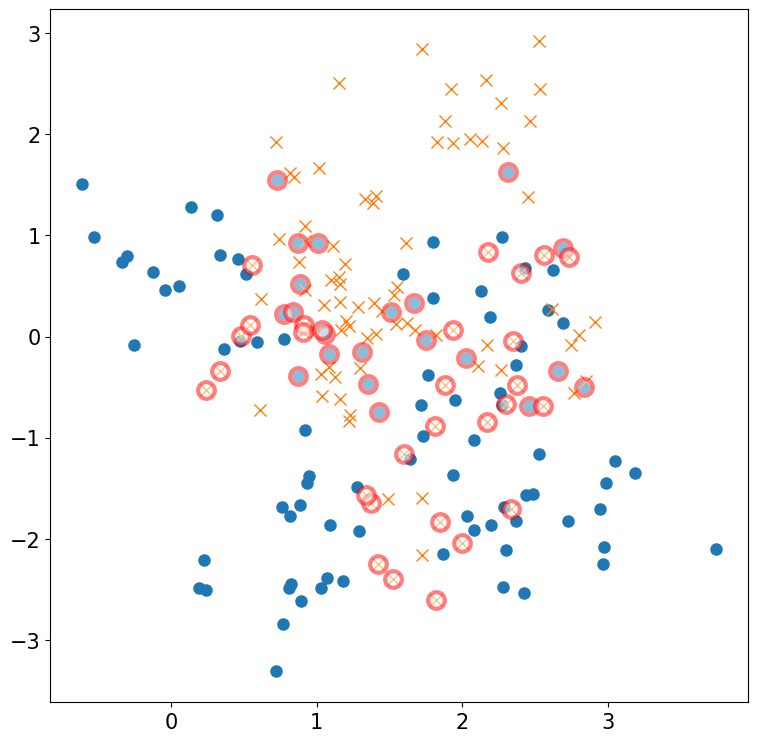

In [61]:
# Coding together #
# Plot data
plt.plot(X[Y == 0, 0], X[Y == 0, 1], "o", markersize=8)
plt.plot(X[Y == 1, 0], X[Y == 1, 1], "x", markersize=8)

# Draw a red circle around misclassified samples
errors = (Y != label)
plt.plot(X[errors, 0], X[errors, 1], "o", color="red", markeredgewidth=3, markerfacecolor="white", markersize=12, alpha=0.5)

As expected, mistakes happen in regions where the majority of points belong to the other class.

But what happens when we try to classify points outside the training set? 

This step is called the **test step**. This is crucial and we must be very careful while doing this. There are a few different ways of assessing this. For instance, we could have used only part of our data in the training set (usually around 80%), and use the remaining to compute the so-called **test error**.Since in our case however the generative model is known, we might as well just get more samples from it.


$\color{darkred}{Caveat}$: Never use samples used in the training step to assess the test performance!

Please pay attention to the previous lines because during the following lectures we will deal always with $\color{blue}{training}$ and $\color{green}{test}$ error. The difference between them is the same that we encounter when considering $\color{green}{learning}$ and  $\color{blue}{memorizing}$: good learning means low test error **NOT** low training error.

In [62]:
# Coding together #
# Sample test data from the model
testsamples_per_class = 10000

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = centroids_class_0[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)
class1_testsamples = centroids_class_1[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), np.ones(testsamples_per_class)))

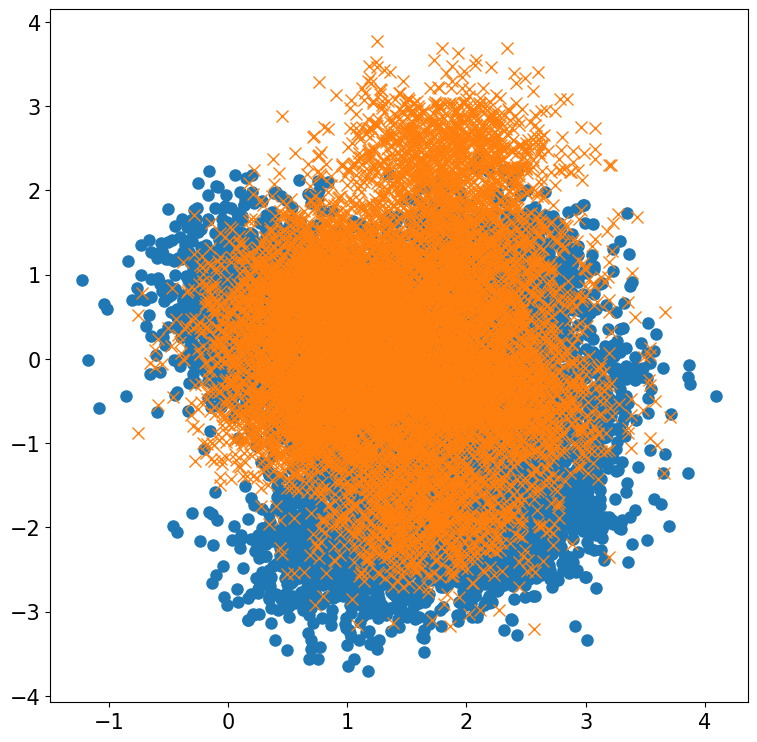

In [63]:
# Coding together #
# Plot test data
plt.plot(X_test[y_test == 0, 0], X_test[y_test == 0, 1], "o", ms=8)
plt.plot(X_test[y_test == 1, 0], X_test[y_test == 1, 1], "x", ms=8)

We now need to write a function similar to `knn` that computes the estimates not for the points on the training set, but for points on a new *test* set.

**Exercise**: 

* Write down the function which compute the estimated labels for a point in the test set at fixed $k$, say $k=10$
* Compute with this function the test error

**Tip**: Only distance between test point and training samples matter! Remember the caveat! 

In [64]:
def knn_test(X_train,y_train, X_test, y_test, k):
    n_test = len(y_test)
    distance = cdist(X_train, X_test)
    estimate = np.zeros(n_test)
     # For each sample in the training set...
    for i in range(n_test):
        # Look up k closest samples
        nns = np.argpartition(distance[:, i], k)[:k]
        
        # Assign estimate as a majority vote
        estimate[i] = int(sum(y_train[nns] == 1) > sum(y_train[nns] == 0))

    return estimate

In [65]:
est_labels = knn_test(X_train=X,X_test=X_test,y_train=Y,y_test=y_test,k=10)
print(est_labels)

# Let us compute the training error
train_error = np.mean(y_test != est_labels)
print(train_error)

[0. 1. 0. ... 1. 0. 1.]
0.38965


Great! 

We computed the relevant quantities which allows us to understnad how the algorithm is performing in this learning task. 

Still something is not clear: **How do I choose $k$?**

Indeed when using $k$-nearest neighbors we have to pick a value for $k$ -- it is not clear in principle how to do it! 

In order to understand this better, let us look at how the training and test errors behave as a function of $k$.

In [66]:
# Convenience functions that compute the training and test errors, given training and test samples
def compute_train_error(X, y, k=1):
    y_hat = knn(X, y, k)
    return np.mean(y != y_hat)
    
def compute_test_error(X_train, y_train, X_test, y_test, k=1):
    y_hat = knn_test(X_train, y_train, X_test, y_test, k)
    return np.mean(y_test != y_hat)

k = 1; train error = 0, test error = 0.40805
k = 2; train error = 0.18, test error = 0.4206
k = 3; train error = 0.235, test error = 0.3985
k = 4; train error = 0.21, test error = 0.4026
k = 5; train error = 0.245, test error = 0.39435
k = 6; train error = 0.255, test error = 0.3995
k = 7; train error = 0.255, test error = 0.3937
k = 8; train error = 0.265, test error = 0.3907
k = 9; train error = 0.27, test error = 0.39385
k = 10; train error = 0.25, test error = 0.38965
k = 11; train error = 0.27, test error = 0.38525
k = 12; train error = 0.305, test error = 0.37845
k = 13; train error = 0.27, test error = 0.37875
k = 14; train error = 0.29, test error = 0.3754
k = 15; train error = 0.255, test error = 0.3761
k = 16; train error = 0.265, test error = 0.3688
k = 17; train error = 0.27, test error = 0.37335
k = 18; train error = 0.285, test error = 0.3643
k = 19; train error = 0.27, test error = 0.36535


Text(0, 0.5, 'misclassification error')

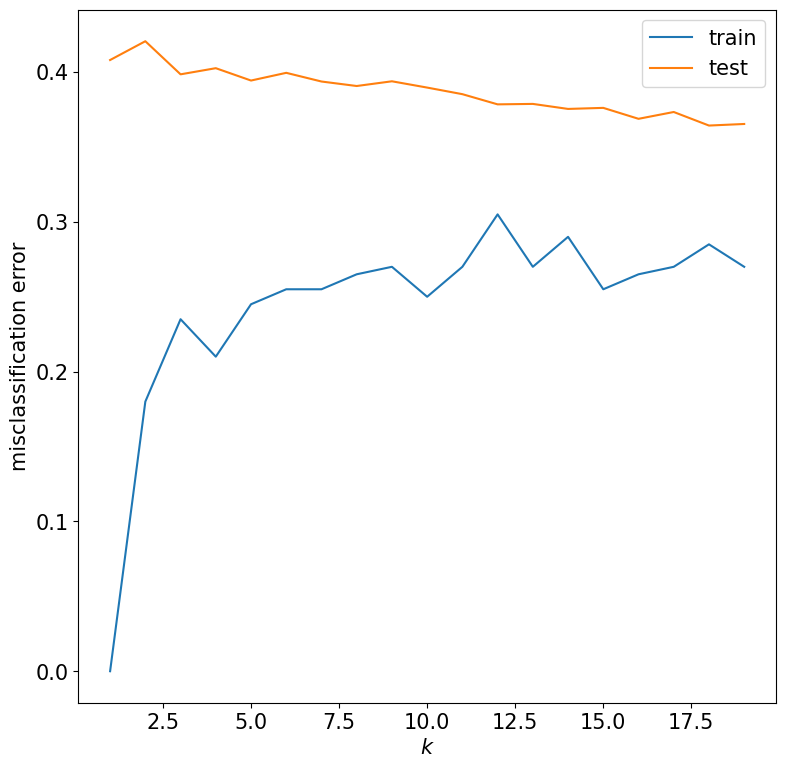

In [67]:
# Run functions for k belonging to a range of values
ks = np.arange(1, 20)
train_error = []
test_error = []
for (i, k) in enumerate(ks):
    train_error.append(compute_train_error(X, Y, k))
    test_error.append(compute_test_error(X, Y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

# Plot results
plt.plot(ks, train_error, label = "train")
plt.plot(ks, test_error, label = "test")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel("misclassification error")

It is instructive to use another quantity in the x axis instead of $k$: the number of **degrees of freedom** $N / k$. 

Indeed, the larger the $k$, the smaller the number of effective parameters -- think for instance of the $k = N$ limit, where everyone is assigned the same label.

## Evaluated question

* Plot the test and training error as a function of $N/k$
* Do you recognize what is going on? Have we seen this phenomena in the theoretical lectures? Discuss in groups and try to understand what is the **key** concept to grasp from this graph (which apply well beyond the specific case of $k$-nearest neighboour)

k = 1; train error = 0, test error = 0.40805
k = 11; train error = 0.27, test error = 0.38525
k = 21; train error = 0.28, test error = 0.36135
k = 31; train error = 0.29, test error = 0.3628
k = 41; train error = 0.295, test error = 0.36465
k = 51; train error = 0.34, test error = 0.3682
k = 61; train error = 0.355, test error = 0.37275
k = 71; train error = 0.355, test error = 0.3717
k = 81; train error = 0.355, test error = 0.3706
k = 91; train error = 0.355, test error = 0.37215
k = 101; train error = 0.35, test error = 0.3726
k = 111; train error = 0.36, test error = 0.37325
k = 121; train error = 0.35, test error = 0.37935
k = 131; train error = 0.36, test error = 0.38595
k = 141; train error = 0.37, test error = 0.3871
k = 151; train error = 0.38, test error = 0.38815
k = 161; train error = 0.365, test error = 0.39225
k = 171; train error = 0.38, test error = 0.3979
k = 181; train error = 0.375, test error = 0.39825
k = 191; train error = 0.37, test error = 0.4029


Text(0, 0.5, 'misclassification error')

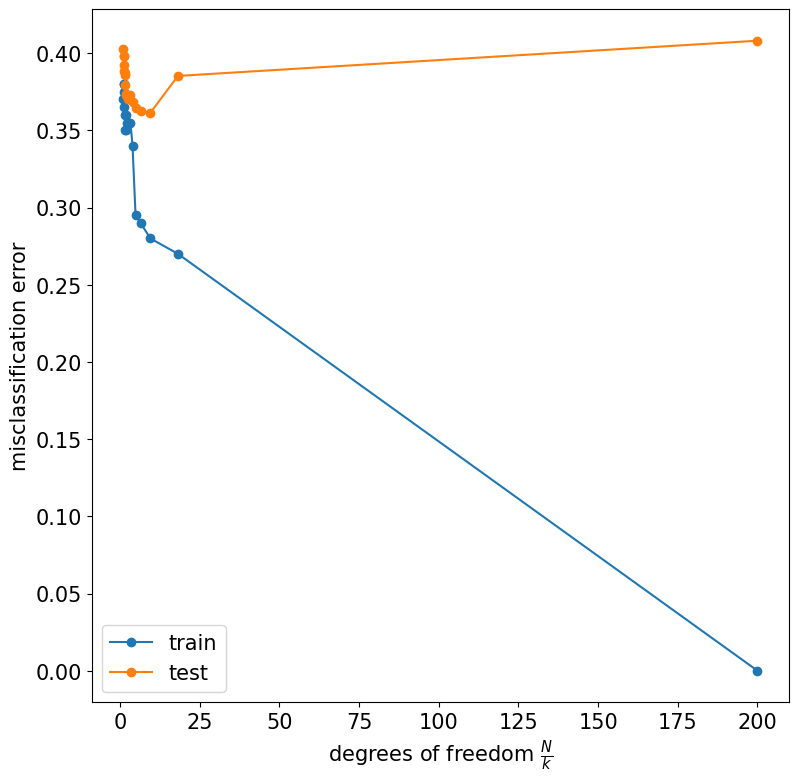

In [68]:
ks = np.arange(1,200,10)
train_error = []
test_error = []
for (i, k) in enumerate(ks):
    train_error.append(compute_train_error(X, Y, k))
    test_error.append(compute_test_error(X, Y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

freedom_degree = len(X)/ks
# Plot results
plt.plot(freedom_degree, train_error, label = "train",marker='o')
plt.plot(freedom_degree, test_error, label = "test", marker='o')
plt.legend()
plt.xlabel(r'degrees of freedom $\frac{N}{k}$')
plt.ylabel("misclassification error")

The plot represents misclassification error on the y-axis and degrees of freedom \(N/K\) on the x-axis, with two lines: one for train error (blue) and another for test error (orange).

\textbf{Train Error:} This shows how well the model fits the training data. The blue line decreases as the model becomes more complex (i.e., as the degrees of freedom increase), approaching zero. This is because a more complex model (lower bias) is able to perfectly memorize the training data.

\textbf{Test Error:} This indicates the model's performance on unseen data (generalization). The orange line first decreases, then starts to increase after a certain point. Initially, a more complex model reduces both train and test errors, but as the model overfits the training data, the test error rises significantly.

\textbf{Bias-Variance Tradeoff:} This plot is a classic illustration of the bias-variance tradeoff, which describes the relationship between model complexity, bias, and variance.

\textbf{Bias:} Bias refers to errors introduced by approximating a complex problem with a simpler model. High bias typically leads to underfitting, where the model is too simple to capture the underlying structure of the data. In the left portion of the plot (low degrees of freedom), the model has high bias, resulting in high error for both the training and test data.

\textbf{Variance:} Variance refers to the sensitivity of the model to small fluctuations in the training data. A high-variance model will perform very well on training data but poorly on test data (overfitting). On the right side of the plot (high degrees of freedom), the model has low bias but high variance, which explains the large gap between the train and test errors.


## Bonus section ##

What we have done so far is to give **estimation** of the class to which a datapoint should belong. In general we don't know where our data comes from (see later when we analyze MNIST dataset for example).

Nonetheless we considered a very special case where we knew that the Generative Model was a Gaussian Mixture Model (GMM) around the sampled centroids.

 During theoretical classes we saw that in these cases the best thing I can do is to do Bayesian inference!

Rephrasing mathematically what we have is: $$P(y = 0|x) \propto P(x| y=0) = GMM(\{m_i^{(0)}\}_{i=1}^{10})  \qquad P(y = 1|x) \propto P(x| y=1) = GMM(\{m_i^{(1)}\}_{i=1}^{10}) $$


Let's code toghether a function that assign estimates in a Bayesian way.

In [69]:
def BayesFunction(class0_centroids,class1_centroids,position):
 diff0 = class0_centroids - position ; diff1 = class1_centroids - position
 exponents0 = np.sum(diff0**2,axis=1) ; exponents1 = np.sum(diff1**2,axis=1)
 p0=sum(np.exp(-2.5*exponents0))
 p1=sum(np.exp(-2.5*exponents1))
 if p0>p1:
  return 0
 else:
  return 1

def ComputeBayesError(class0_centroids,class1_centroids,label,pos):
 frac=0
 for i in range(max(pos.shape)):
  pred = BayesFunction(class0_centroids,class1_centroids,pos[i])
  if pred != label[i]:
     frac=frac+1
 return frac/max(pos.shape)

**Exercise**:
- Compute the Bayesian error on the training and on the test set
- Plot the Bayesian test error along with the curves of the previous exercise. How does it look like? What can you conclude?

In [70]:
training_error_bayesian = ComputeBayesError(centroids_class_0,centroids_class_1,Y,X)
test_error_bayesian = ComputeBayesError(centroids_class_0,centroids_class_1,y_test,X_test)

Text(0, 0.5, 'misclassification error')

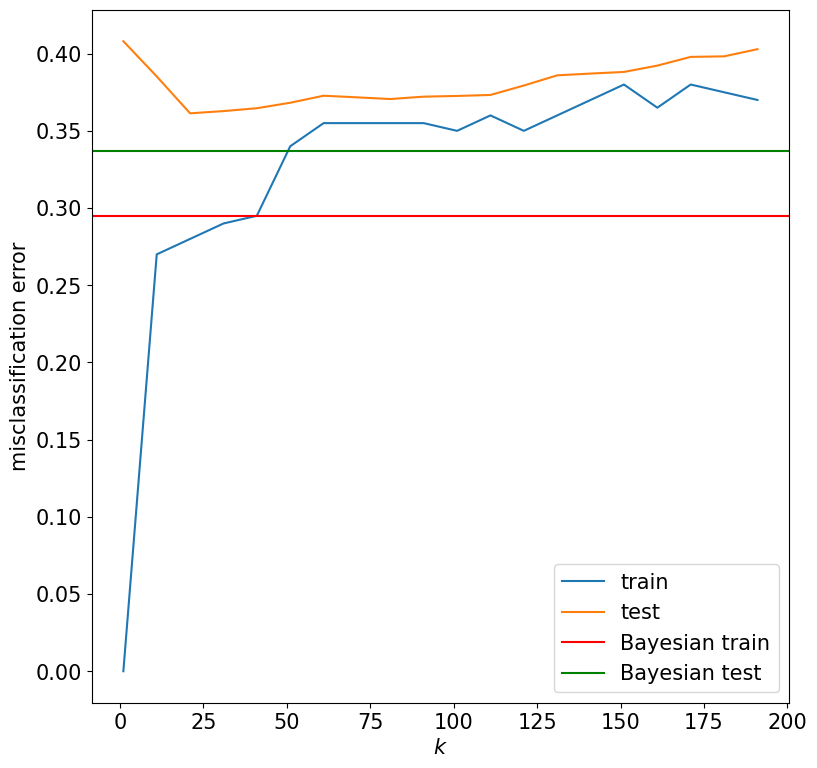

In [71]:
plt.plot(ks, train_error, label = "train")
plt.plot(ks, test_error, label = "test")
plt.axhline(training_error_bayesian, label="Bayesian train", color='r')
plt.axhline(test_error_bayesian, label="Bayesian test", color='g')
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel("misclassification error")

It is possible to see that the Bayesian test remains contains with a avrying k, but most importantely it is always better than the KNN for the test error